In [1]:
%matplotlib inline


# STEPS nowcast

This tutorial shows how to compute and plot an ensemble nowcast using Swiss
radar data.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from pprint import pprint
from pysteps import io, nowcasts, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field

# Set nowcast parameters
n_ens_members = 20
n_leadtimes = 6
seed = 24

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read precipitation field

First thing, the sequence of Swiss radar composites is imported, converted and
transformed into units of dBR.



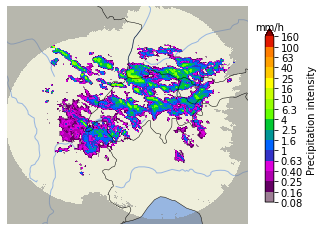

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': -10.0,
 'timestamps': array([datetime.datetime(2017, 1, 31, 11, 50),
       datetime.datetime(2017, 1, 31, 11, 55),
       datetime.datetime(2017, 1, 31, 12, 0)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 255000.0,
 'x2': 965000.0,
 'xpixelsize': 2000,
 'y1': -160000.0,
 'y2': 480000.0,
 'yorigin': 'upper',
 'ypixelsize': 2000,
 'zerovalue': -15.0,
 'zr_a': 316.0,
 'zr_b': 1.5}


In [3]:
date = datetime.strptime("201701311200", "%Y%m%d%H%M")
data_source = "mch"

# Load data source config
root_path = rcparams.data_sources[data_source]["root_path"]
path_fmt = rcparams.data_sources[data_source]["path_fmt"]
fn_pattern = rcparams.data_sources[data_source]["fn_pattern"]
fn_ext = rcparams.data_sources[data_source]["fn_ext"]
importer_name = rcparams.data_sources[data_source]["importer"]
importer_kwargs = rcparams.data_sources[data_source]["importer_kwargs"]
timestep = rcparams.data_sources[data_source]["timestep"]

# Find the radar files in the archive
fns = io.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_prev_files=2
)

# Read the data from the archive
importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to rain rate
R, metadata = conversion.to_rainrate(R, metadata)

# Upscale data to 2 km to limit memory usage
R, metadata = dimension.aggregate_fields_space(R, metadata, 2000)

# Plot the rainfall field
plot_precip_field(R[-1, :, :], geodata=metadata)
plt.show()

# Log-transform the data to unit of dBR, set the threshold to 0.1 mm/h,
# set the fill value to -15 dBR
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Set missing values with the fill value
R[~np.isfinite(R)] = -15.0

# Nicely print the metadata
pprint(metadata)

## Deterministic nowcast with S-PROG

First, the motiong field is estimated using a local tracking approach based
on the Lucas-Kanade optical flow.
The motion field can then be used to generate a deterministic nowcast with
the S-PROG model, which implements a scale filtering appraoch in order to
progressively remove the unpredictable spatial scales during the forecast.



Computing S-PROG nowcast:
-------------------------

Inputs:
-------
input dimensions: 320x355

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     6
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.999280      | 0.997264      |
-----------------------------------------
| 2     | 0.998009      | 0.991419      |
-----------------------------------------
| 3     | 0.990730      | 0.968632      |
----------------

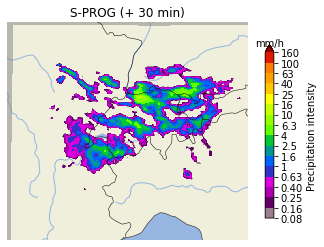

In [4]:
# Estimate the motion field
V = dense_lucaskanade(R)

# The S-PROG nowcast
nowcast_method = nowcasts.get_method("sprog")
R_f = nowcast_method(
    R[-3:, :, :],
    V,
    n_leadtimes,
    n_cascade_levels=6,
    R_thr=-10.0,
)

# Back-transform to rain rate
R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]

# Plot the S-PROG forecast
plot_precip_field(
    R_f[-1, :, :],
    geodata=metadata,
    title="S-PROG (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

As we can see from the figure above, the forecast produced by S-PROG is a
smooth field. In other words, the forecast variance is lower than the
variance of the original observed field.
However, certain applications demand that the forecast retain the same
statistical properties of the observations. In such cases, the S-PROG
forecasts are of limited use and a stochatic approach might be of more
interest.



## Stochastic nowcast with STEPS

The S-PROG approach is extended to include a stochastic term which represents
the variance associated to the unpredictable development of precipitation. This
approach is known as STEPS (short-term ensemble prediction system).



Computing STEPS nowcast:
------------------------

Inputs:
-------
input dimensions: 320x355
km/pixel:         2
time step:        5 minutes

Methods:
--------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters:
-----------
number of time steps:     6
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-------------------------------------

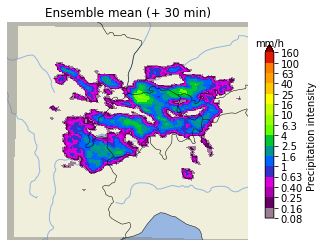

In [5]:
# The STEPS nowcast
nowcast_method = nowcasts.get_method("steps")
R_f = nowcast_method(
    R[-3:, :, :],
    V,
    n_leadtimes,
    n_ens_members,
    n_cascade_levels=6,
    R_thr=-10.0,
    kmperpixel=2.0,
    timestep=timestep,
    noise_method="nonparametric",
    vel_pert_method="bps",
    mask_method="incremental",
    seed=seed,
)

# Back-transform to rain rates
R_f = transformation.dB_transform(R_f, threshold=-10.0, inverse=True)[0]


# Plot the ensemble mean
R_f_mean = np.mean(R_f[:, -1, :, :], axis=0)
plot_precip_field(
    R_f_mean,
    geodata=metadata,
    title="Ensemble mean (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

The mean of the ensemble displays similar properties as the S-PROG
forecast seen above, although the degree of smoothing also depends on
the ensemble size. In this sense, the S-PROG forecast can be seen as
the mean of an ensemble of infinite size.



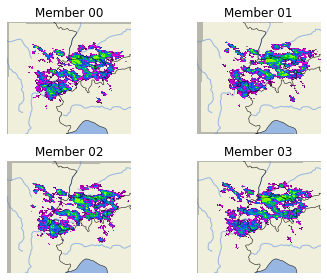

In [6]:
# Plot some of the realizations
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax = plot_precip_field(
        R_f[i, -1, :, :], geodata=metadata, colorbar=False, axis="off"
    )
    ax.set_title("Member %02d" % i)
plt.tight_layout()
plt.show()

As we can see from these two members of the ensemble, the stochastic forecast
mantains the same variance as in the observed rainfall field.
STEPS also includes a stochatic perturbation of the motion field in order
to quantify the its uncertainty.



Finally, it is possible to derive probabilities from our ensemble forecast.



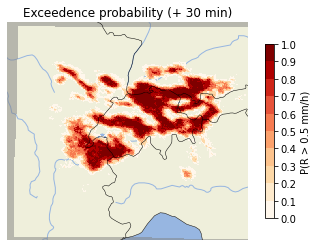

In [7]:
# Compute exceedence probabilities for a 0.5 mm/h threshold
P = excprob(R_f[:, -1, :, :], 0.5)

# Plot the field of probabilities
plot_precip_field(
    P,
    geodata=metadata,
    ptype="prob",
    units="mm/h",
    probthr=0.5,
    title="Exceedence probability (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

# sphinx_gallery_thumbnail_number = 5